In [165]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib import animation
import pyproj
from IPython.display import HTML

In [166]:
def calc_slope(mnt):

    if np.ndim(mnt) == 1:
        slope = np.abs(np.gradient(mnt))
    else:
        dx, dy = np.gradient(mnt)
        slope = np.sqrt(np.clip(dx**2 + dy**2, 0, 1e6)) #La fonction clip sert à éviter les valeurs trop grandes qui pourraient faire crasher le programme.

    slope = np.maximum(slope, 1e-3)
    return slope

In [167]:
def erosion_glaciaire(mnt, K, A):
    
    m=0.5
    n=1

    S = calc_slope(mnt)
    
    E = K * (A**m) * (S**n) 
    
    return E

In [168]:
def app_erosion_glaciaire(mnt, K, time, type, stop):
    
    list_mnt = []  

    if type == "simple":
        A =1
        
    elif type == "math":
        w = int(input("Veuillez entrer la largeur du glacier : "))
        
        A = np.full_like(mnt,0)
        
        if np.ndim(mnt) ==1:
            l = np.shape(mnt)[0]
            sigma = w/2
            mu = l/2
            
            x = np.linspace(0, np.shape(mnt)[0], np.shape(mnt)[0])
       
            A[(np.abs(x) <= mu + sigma) & (np.abs(x) >= mu - sigma)] = 1
            A[np.abs(x) > mu + sigma] = np.exp(-(x[np.abs(x)> mu + sigma] - mu)**2 / (2 * sigma**2))
            A[np.abs(x) < mu - sigma] = np.exp(-(x[np.abs(x) < mu - sigma] - mu)**2 / (2 * sigma**2))

        elif np.ndim(mnt) == 2:
            l = np.shape(mnt)[1]
            sigma = w/2
            mu = l/2
            
            X = np.linspace(0, np.shape(mnt)[1], np.shape(mnt)[1])
            Y = np.linspace(0, np.shape(mnt)[0], np.shape(mnt)[0])
            X, Y = np.meshgrid(X, Y)
              
            A[(np.abs(X) <= mu + sigma) & (np.abs(X) >= mu - sigma)] = 1  
            A[np.abs(X) > mu + sigma] = np.exp(-(X[np.abs(X) > mu + sigma] - mu)**2 / (2 * sigma**2))
            A[np.abs(X) < mu - sigma] = np.exp(-(X[np.abs(X) < mu - sigma] - mu)**2 / (2 * sigma**2))

    
    elif type == "alt":
        seuil_min = int(input("Veuillez entrer une altitude minimale pour le glacier : "))
        seuil_max = int(input("Veuillez entrer une altitude maximale pour le glacier : "))
        
        delta = (seuil_max - seuil_min)/2
        moy = delta = (seuil_max + seuil_min)/2
        
        A = np.full_like(mnt,0)
        
        if np.ndim(mnt) == 1:
            x = np.linspace(0, np.shape(mnt)[0], np.shape(mnt)[0])
            
            A[(mnt <= seuil_max) & (mnt>=seuil_min)] = 1
            A[mnt < seuil_min] = np.exp(-(mnt[mnt < seuil_min] - moy)**2/(2*delta**2))
            A[mnt > seuil_max] = np.exp(-(mnt[mnt > seuil_max] - moy)**2/(2*delta**2))
            
        elif np.ndim(mnt) == 2:
            A = np.full_like(mnt,0)
        
            A[(mnt <= seuil_max) & (mnt>=seuil_min)] = 1
            A[mnt < seuil_min] = np.exp(-(mnt[mnt < seuil_min] - moy)**2/(2*delta**2))
            A[mnt > seuil_max] = np.exp(-(mnt[mnt > seuil_max] - moy)**2/(2*delta**2))
            
        
    for t in range(time): #On applique l'érosion sur plusieurs itérations
        
        mnt -= erosion_glaciaire(mnt, K, A)
        
        list_mnt.append(mnt.copy())  # Copie pour éviter l'écrasement des données
        
        if stop == True: #permet d'arrêter les itérations si on atteint une valeur nulle.
            if np.any(mnt <= 0):
                print("STOP à l'itération", t)
                break
        
    return list_mnt

In [169]:
def erosion_fluviale(mnt, K, A):
    m = 0.5
    n=1
    
    S = calc_slope(mnt)
    E = K * (A**m) * (S**n) 
    
    return E

In [170]:
def app_erosion_fluviale(mnt, K, time, river_width,stop, décalage):
    longueur = np.shape(mnt)[0]
    x = np.linspace(0,longueur, longueur)
    
    list_mnt = []    
    
    sigma = river_width/2
    mu = longueur/2
    
    A = np.exp(-(x-mu - décalage)**2/(2*sigma**2))
    
    for t in range(time):
        
        mnt -= erosion_fluviale(mnt, K, A)
        list_mnt.append(mnt.copy())  # Copie pour éviter l'écrasement des données
        
        if stop == True:
            if np.any(mnt <= 0):
                print("STOP à l'itération", t)  #Permet d'arrêter les itérations si une des valeurs du terrain arrive à 0.
                break
        
    return list_mnt

# Terrain plat

## 1. Erosion fluviale

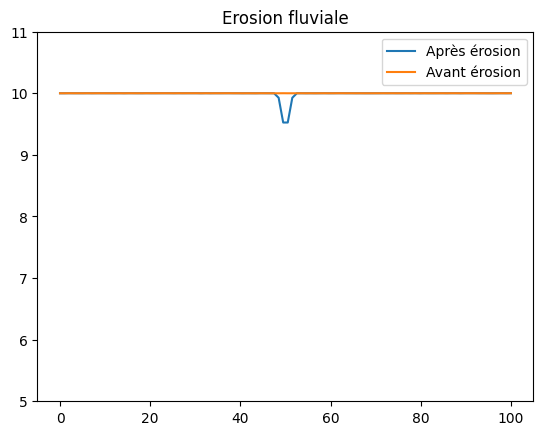

In [180]:
h = 10
x = np.linspace(0,100,100)

y_0 = h*x**0

y_0 += 1e-3*np.random.rand(np.size(x))

y_1 = app_erosion_fluviale(y_0.copy(),K=0.1, time=200, river_width = 1, stop = True, décalage = 0)


plt.ylim(5,h +h/10)

plt.plot(x,y_1[-1], label = "Après érosion")
plt.plot(x,y_0, label = "Avant érosion")
plt.title("Erosion fluviale")
plt.legend()
plt.show()

## 2. Erosion glaciaire

Veuillez entrer la largeur du glacier :  30


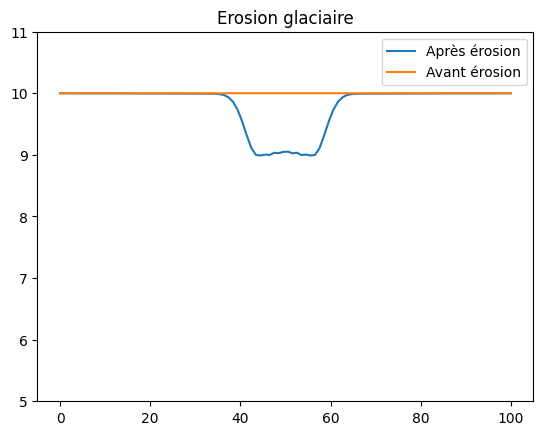

In [181]:
y_2 = app_erosion_glaciaire(y_1[-1].copy(),K=0.01, time=1000, stop = True, type = "math")


plt.ylim(5,h +h/10)
plt.plot(x,y_2[-1], label = "Après érosion")
plt.plot(x,y, label = "Avant érosion")
plt.title("Erosion glaciaire")
plt.legend()
plt.show()

## 4. Erosion fluviale

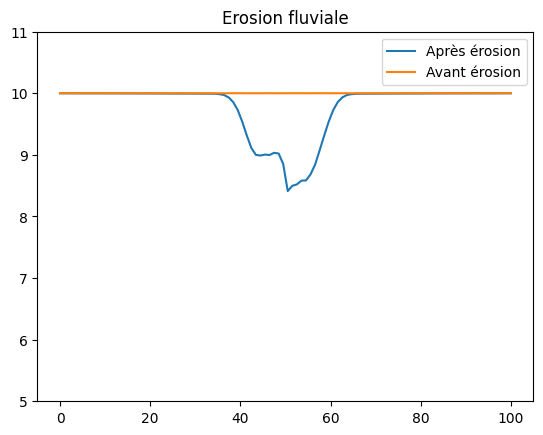

In [182]:
y_3 = app_erosion_fluviale(y_2[-1].copy(),K=0.1, time=400, river_width = 2, stop = True, décalage = 3)


plt.ylim(5,h +h/10)

plt.plot(x,y_3[-1], label = "Après érosion")
plt.plot(x,y, label = "Avant érosion")
plt.title("Erosion fluviale")
plt.legend()
plt.show()

## 4. Erosion glaciaire

Veuillez entrer la largeur du glacier :  90


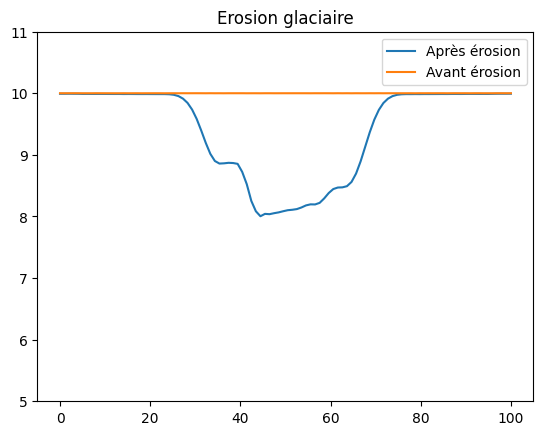

In [183]:
y_4 = app_erosion_glaciaire(y_3[-1].copy(),K=0.01, time=1000, stop = True, type = "math")


plt.ylim(5,h +h/10)
plt.plot(x,y_4[-1], label = "Après érosion")
plt.plot(x,y, label = "Avant érosion")
plt.title("Erosion glaciaire")
plt.legend()
plt.show()

## 5. Erosion fluviale

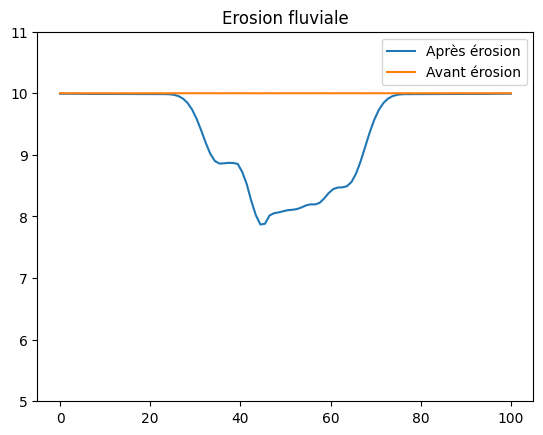

In [186]:
y_5 = app_erosion_fluviale(y_4[-1].copy(),K=0.1, time=50, river_width = 1, stop = True, décalage = -5)


plt.ylim(5,h +h/10)

plt.plot(x,y_5[-1], label = "Après érosion")
plt.plot(x,y, label = "Avant érosion")
plt.title("Erosion fluviale")
plt.legend()
plt.show()

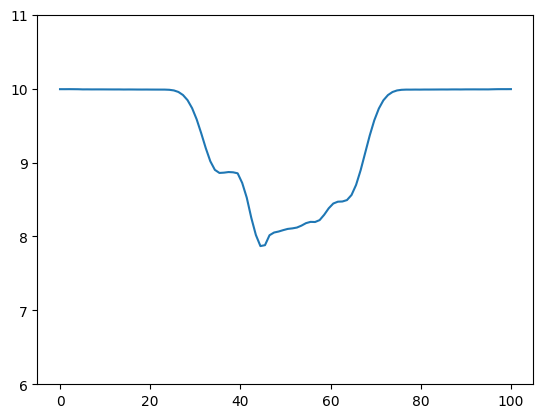

In [198]:

plt.plot(x,y_5[-1])
'''
plt.plot(x,y_4[-1])
plt.plot(x,y_3[-1])
plt.plot(x,y_2[-1])
plt.plot(x,y_1[-1])
'''
plt.ylim(6,11)
#plt.plot(x,y_0)
plt.show()